Loading YOLO model...


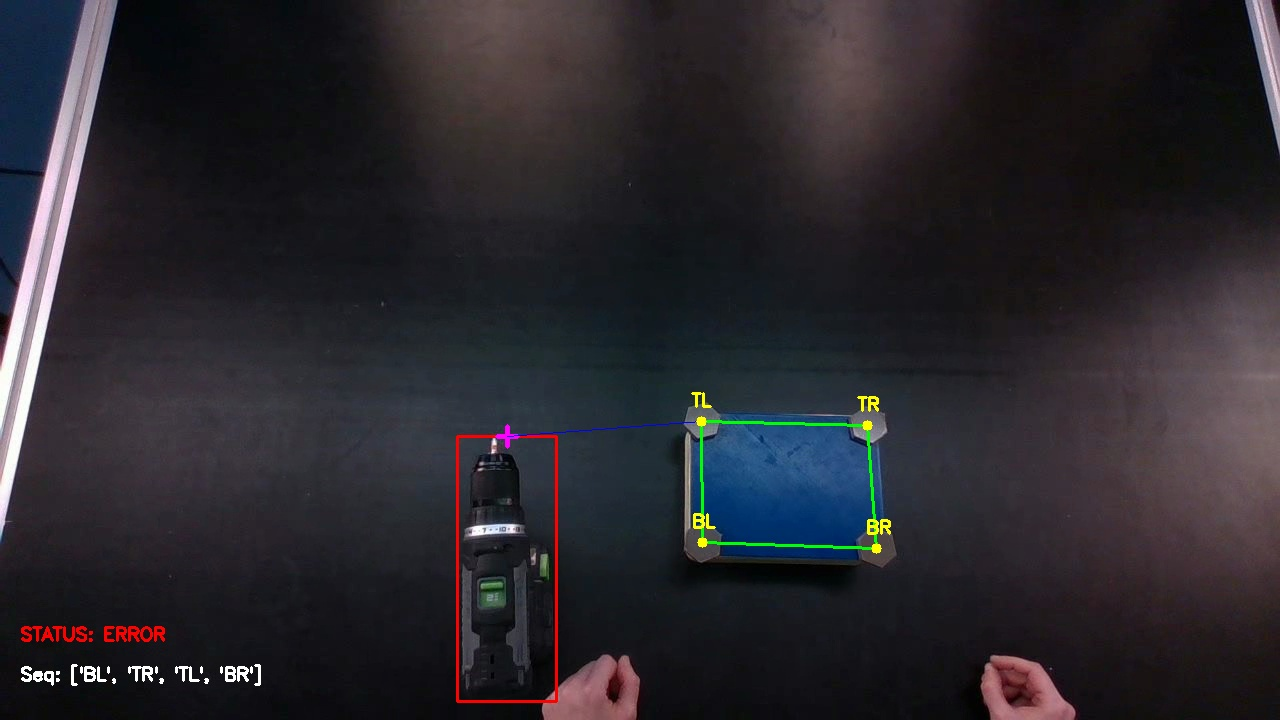

Tool Calibrated.
LOCKED!

Final Sequence: ['BL', 'TR', 'TL', 'BR']

Correct Sequence: ['BL', 'TR', 'BR', 'TL']


In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
from IPython.display import display, Image

# CONFIGURATION
VIDEO_PATH = '137322071489.mp4'  
MODEL_PATH = 'best.pt'
PROCESS_LAST_SECONDS = 35

# CLASS IDs
TOOL_CLASS_ID = 5   
SCREW_CLASS_ID = 4  

# SETTINGS
PLAYBACK_SPEED_X = 2        
DWELL_FRAMES = 5
REQUIRED_ORDER = ['BL', 'TR', 'BR', 'TL'] 

TRACKING_SETTINGS = {
    'STRICT_HIT_RADIUS': 75,      
    'MIN_BOX_WIDTH_PX': 80,      
    'TOOL_INIT_FRAMES': 3,        
    'PICKUP_THRESHOLD_PX': 20     
}

# GLOBAL STATE 
fixed_sequence = []
current_zone_focus = None
focus_counter = 0

box_state = {
    'locked': False,
    'ref_shape': None,    
    'curr_points': None,  
    'labels': ['TL', 'TR', 'BR', 'BL']
}

tool_state = {
    'start_pos': None,
    'init_buffer': []
}

prev_tool_pos = None

def draw_text(img, text, pos, color=(0, 255, 0), scale=0.6, thickness=2):
    cv2.putText(img, text, pos, cv2.FONT_HERSHEY_SIMPLEX, scale, color, thickness)

def order_points_clockwise(pts):
    pts = pts[pts[:, 1].argsort()]
    top = pts[:2]
    bottom = pts[2:]
    top = top[top[:, 0].argsort()]
    bottom = bottom[bottom[:, 0].argsort()]
    return np.array([top[0], top[1], bottom[1], bottom[0]], dtype="float32")

def lock_box(screw_boxes):
    centers = np.array([[s['cx'], s['cy']] for s in screw_boxes])
    if len(centers) != 4: return None, f"NEED 4 POINTS (GOT {len(centers)})"

    ordered = order_points_clockwise(centers)
    return {
        'ref_shape': ordered,     
        'curr_points': ordered,   
        'labels': ['TL', 'TR', 'BR', 'BL']
    }, "OK"

def update_rigid_tracking(detections, state):
    if not detections or state['ref_shape'] is None: 
        return state

    obs_points = np.array([[d['cx'], d['cy']] for d in detections], dtype="float32")
    last_known = state['curr_points']
    ref_shape = state['ref_shape']
    
    pairs = []
    for i, known_pt in enumerate(last_known):
        dists = np.linalg.norm(obs_points - known_pt, axis=1)
        for j, d in enumerate(dists):
            if d < 80: 
                pairs.append((i, j, d))
    
    pairs.sort(key=lambda x: x[2])
    
    src_pts = []
    dst_pts = []
    used_known = set()
    used_obs = set()
    
    for i, j, d in pairs:
        if i not in used_known and j not in used_obs:
            src_pts.append(ref_shape[i])
            dst_pts.append(obs_points[j])
            used_known.add(i)
            used_obs.add(j)
            
    src_pts = np.array(src_pts)
    dst_pts = np.array(dst_pts)
    
    M = None
    if len(dst_pts) >= 2:
        M, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts)
        
    if M is not None:
        ref_reshaped = ref_shape.reshape(-1, 1, 2)
        transformed = cv2.transform(ref_reshaped, M)
        state['curr_points'] = transformed.reshape(4, 2)
        
    return state

def merge_tool_boxes(boxes):
    if not boxes: return None
    x1s = [b[0] for b in boxes]; y1s = [b[1] for b in boxes]
    x2s = [b[2] for b in boxes]; y2s = [b[3] for b in boxes]
    return (min(x1s), min(y1s), max(x2s), max(y2s))

def main():
    global box_state, current_zone_focus, focus_counter, prev_tool_pos, tool_state
    
    print("Loading YOLO model...")
    model = YOLO(MODEL_PATH)
    
    cap = cv2.VideoCapture(VIDEO_PATH)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    if fps > 0:
        start_sec = max(0, (total_frames / fps) - PROCESS_LAST_SECONDS)
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(start_sec * fps))
        
    display_handle = display(None, display_id=True)
    frame_idx = 0

    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret: break
            frame_idx += 1
            if frame_idx % PLAYBACK_SPEED_X != 0: continue

            # 1. DETECTION 
            results = model(frame, verbose=False)[0]
            screw_dets = []
            tool_boxes_raw = []
            
            for box in results.boxes.data:
                x1, y1, x2, y2, conf, cls = box.tolist()
                if int(cls) == SCREW_CLASS_ID and conf > 0.15:
                    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
                    screw_dets.append({'cx': cx, 'cy': cy, 'conf': conf})
                    if not box_state['locked']:
                        cv2.circle(frame, (int(cx), int(cy)), 3, (255, 200, 0), -1)

                elif int(cls) == TOOL_CLASS_ID and conf > 0.35:
                    tool_boxes_raw.append((x1, y1, x2, y2))
            
            # 2. MERGE LOGIC 
            final_tool_box = merge_tool_boxes(tool_boxes_raw)
            
            current_tip = None
            if final_tool_box:
                x1, y1, x2, y2 = final_tool_box
                cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)
                # STRICT TOP-CENTER TIP
                current_tip = np.array([(x1+x2)/2, y1])

            # 3. LOGIC 
            if not box_state['locked']:
                if current_tip is not None:
                    # Calibration
                    if tool_state['start_pos'] is None:
                        tool_state['init_buffer'].append(current_tip)
                        if len(tool_state['init_buffer']) > TRACKING_SETTINGS['TOOL_INIT_FRAMES']:
                            tool_state['start_pos'] = np.mean(tool_state['init_buffer'], axis=0)
                            print("Tool Calibrated.")
                    else:
                        sx, sy = tool_state['start_pos']
                        cv2.line(frame, (int(sx), int(sy)), (int(current_tip[0]), int(current_tip[1])), (0, 100, 255), 1)
                        dist = np.linalg.norm(current_tip - tool_state['start_pos'])
                        
                        # FAST START LOGIC 
                        if dist > TRACKING_SETTINGS['PICKUP_THRESHOLD_PX']:
                            if len(screw_dets) >= 4: 
                                screw_dets.sort(key=lambda x: x['conf'], reverse=True)
                                data, reason = lock_box(screw_dets[:4])
                                if data:
                                    box_state.update(data)
                                    box_state['locked'] = True
                                    print("LOCKED!")
            else:
                # TRACKING
                box_state = update_rigid_tracking(screw_dets, box_state)
                corners = box_state['curr_points']
                labels = box_state['labels']
                
                # Draw Box
                pts = corners.astype(np.int32).reshape((-1, 1, 2))
                cv2.polylines(frame, [pts], True, (0, 255, 0), 2)
                
                active_zone = None
                
                if current_tip is not None:
                    # Draw Tip
                    cv2.drawMarker(frame, (int(current_tip[0]), int(current_tip[1])), (255, 0, 255), cv2.MARKER_CROSS, 20, 3)
                    
                    dists = [np.linalg.norm(current_tip - c) for c in corners]
                    min_dist = min(dists)
                    nearest_idx = dists.index(min_dist)
                    
                    t_pt = corners[nearest_idx]
                    cv2.line(frame, (int(current_tip[0]), int(current_tip[1])), (int(t_pt[0]), int(t_pt[1])), (255, 0, 0), 1)

                    is_stable = False
                    if prev_tool_pos is not None:
                         speed = np.linalg.norm(current_tip - prev_tool_pos)
                         if speed < 40.0: is_stable = True
                    prev_tool_pos = current_tip
                    
                    if min_dist < TRACKING_SETTINGS['STRICT_HIT_RADIUS']:
                        target = labels[nearest_idx]
                        cv2.line(frame, (int(current_tip[0]), int(current_tip[1])), (int(t_pt[0]), int(t_pt[1])), (0, 255, 0), 3)
                        
                        if is_stable:
                            active_zone = target

                # Labels
                for i, pt in enumerate(corners):
                    c = (0, 255, 255)
                    if active_zone == labels[i]: c = (0, 255, 0)
                    cx, cy = int(pt[0]), int(pt[1])
                    cv2.circle(frame, (cx, cy), 5, c, -1)
                    cv2.putText(frame, labels[i], (cx-10, cy-15), cv2.FONT_HERSHEY_SIMPLEX, 0.6, c, 2)

                # Sequence
                if active_zone and is_stable:
                    if active_zone == current_zone_focus:
                        focus_counter += 1
                    else:
                        current_zone_focus = active_zone
                        focus_counter = 1
                    
                    if active_zone not in fixed_sequence:
                        bar = int((focus_counter/DWELL_FRAMES)*50)
                        cv2.rectangle(frame, (50, 60), (50+bar, 70), (0, 255, 0), -1)
                        if focus_counter > DWELL_FRAMES:
                            fixed_sequence.append(active_zone)
                            focus_counter = 0
                else:
                    focus_counter = 0

            # UI
            status = f"Seq: {fixed_sequence}"
            correct = (fixed_sequence == REQUIRED_ORDER[:len(fixed_sequence)])
            color = (0, 255, 0) if correct else (0, 0, 255)
            draw_text(frame, status, (20, frame.shape[0]-40), (255,255,255))
            draw_text(frame, "STATUS: OK" if correct else "STATUS: ERROR", (20, frame.shape[0]-80), color)

            _, jpeg = cv2.imencode('.jpg', frame)
            display_handle.update(Image(data=jpeg.tobytes()))

    except KeyboardInterrupt:
        print("Stopped.")

    cap.release()
    print(f"\nFinal Sequence: {fixed_sequence}")
    print(f"\nCorrect Sequence: {REQUIRED_ORDER}")

if __name__ == "__main__":
    main()